<a href="https://colab.research.google.com/github/trolloloshka12/123/blob/main/Copy_of_%5B%D0%A1%D1%82%D1%83%D0%B4%D0%B5%D0%BD%D1%82%D1%83%5D_13_%D0%B1%D0%B0%D0%B7%D0%BE%D0%B2%D0%BE%D0%B5_%D0%94%D0%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

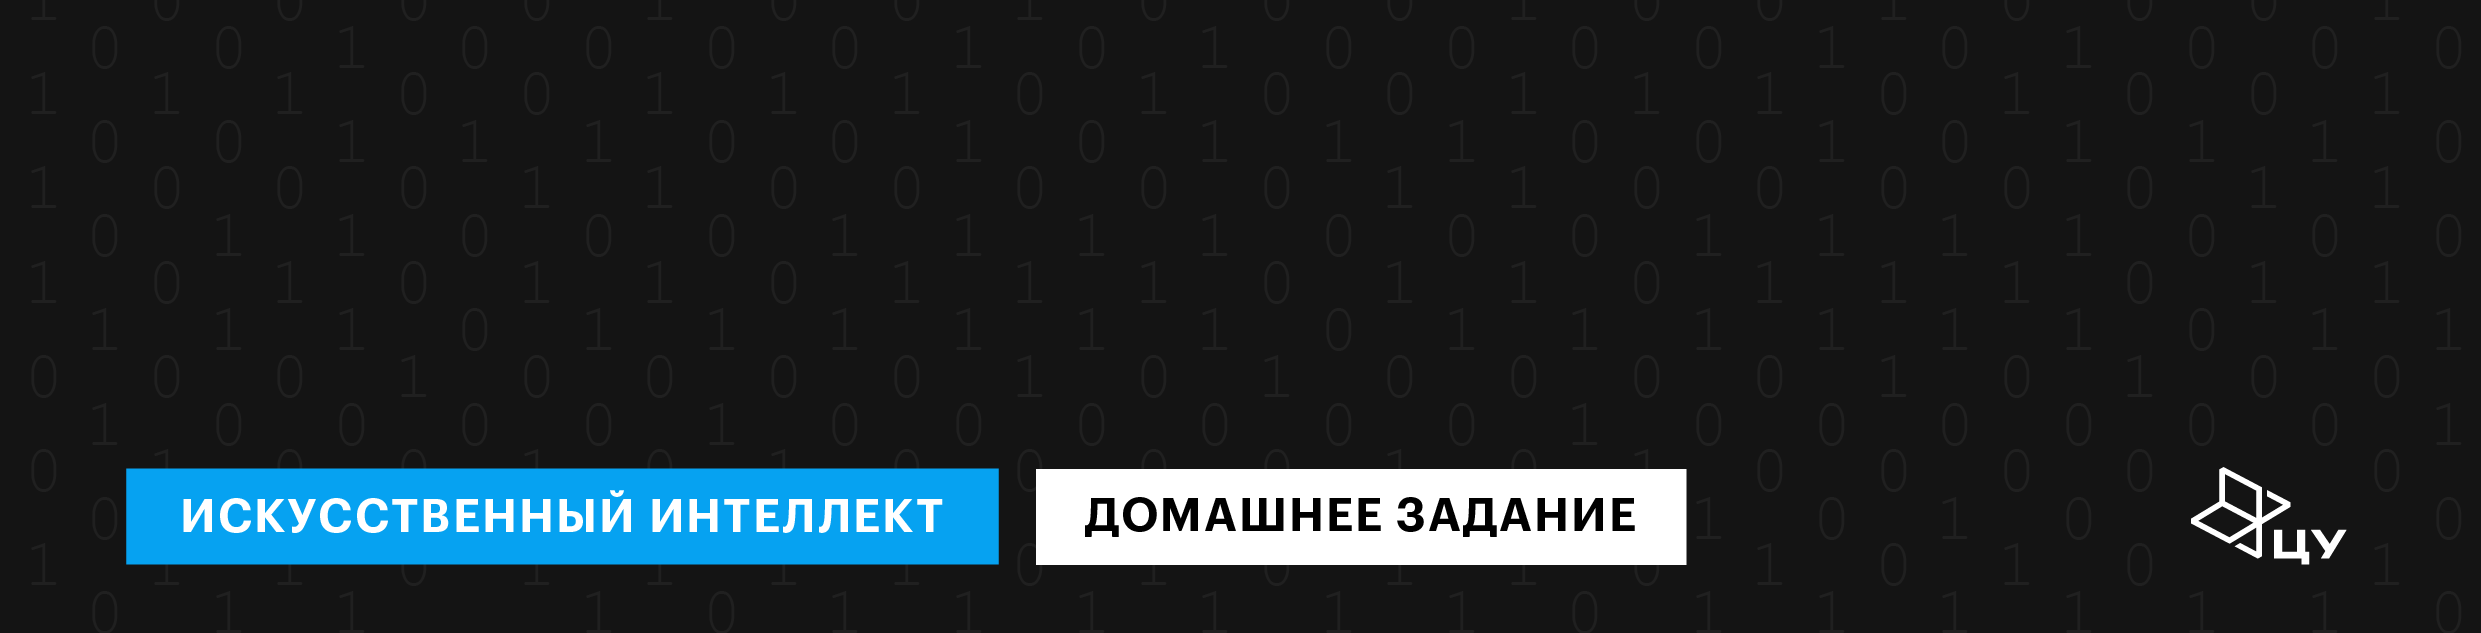

# Домашнее задание на тему «Обучение с подкреплением»

## Подготовка
Скачай и установи библиотеки.

In [ ]:
!pip install -q gymnasium
!touch .setup_complete

In [ ]:
!pip install shimmy

Не беспокойся, это займёт примерно минуту.

In [ ]:
!pip install stable-baselines3[extra] gym

Импортируй всё необходимое.

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import gymnasium as gym


Ниже — код для визуализации.

In [ ]:
# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from matplotlib import rc
rc('animation', html='jshtml')
sns.set_style("whitegrid", {'axes.grid' : False})

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save('./CartPole_results.gif', writer='pillow', fps=30)
    return anim

## Cart Pole

Cart Pole — это классическая среда обучения с подкреплением. Она предоставлятся библиотекой OpenAI Gym.

Цель в этой среде: уравновесить тележку.

Шест прикреплён с помощью неуправляемого шарнира к тележке, которая движется по дорожке без трения. Нужно сбалансировать шест, прикладывая усилия к тележке в левом и правом направлениях.

Размерность пространства действий (action space) одномерна и может принимать одно из двух значений:
  - 0 — толкать тележку влево;
  - 1 — толкать тележку вправо.

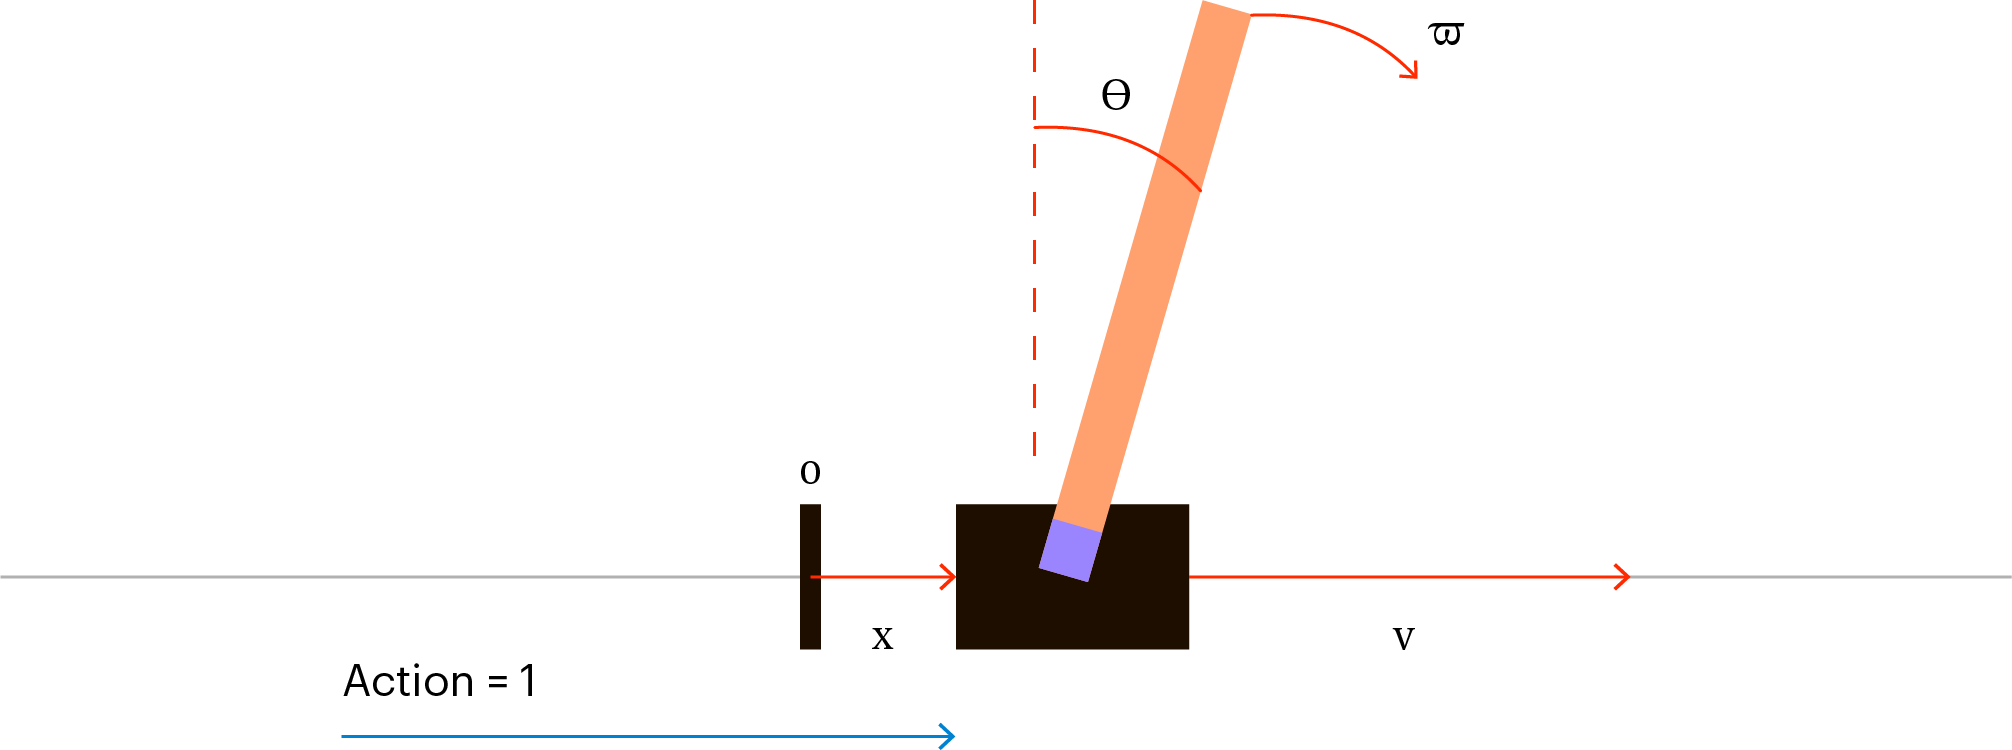

[Источник](https://gymnasium.farama.org/environments/classic_control/cart_pole/)


*  Доступны два действия — перемещение тележки влево или вправо:
`actions = {'left':0, 'right':1}`.

*  Награда начисляется за каждую секунду, в течение которой шест остаётся в вертикальном положении.

*  Состояние среды складывается из 4 параметров: положения тележки ($x$), скорости тележки (v), угла наклона шеста ($Θ$), угловой скорости шеста ($ω$).

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

plt.imshow(env.render())
print("Пространство наблюдений:", env.observation_space)
print("Пространство действий:", env.action_space)


### Описание интерфейса `gymnasium`

Три основных метода окружения:
* `reset()` — возвращает окружение в начальное состояние, возвращает первое наблюдение и `dict`(словарь) со вспомогательной информацией;
* `render()` — показывает текущее состояние окружения (более красочная версия);
* `step(a)` — выполняет действие `a` и возвращает `new_observation, reward, terminated, truncated, info`.
 * `new_observation`: наблюдение сразу после совершения действия `a`.
 * `reward`: число, представляющее награду за выполнение действия `a`.
 * `terminated`: `True`, если MDP только что завершился, `False`, если всё ещё продолжается.
 * `truncated`: `True`, если количество пройденных шагов >= `max episode steps`.
 * `info`: некоторые вспомогательные данные о том, что только что произошло. На этот пункт пока не нужно обращать внимание.

Подробное объяснение разницы между `terminated` и `truncated`:
https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/.



Посмотрим на среду.

In [ ]:
# Установи seed для воспроизведения начального состояния в стохастической среде
obs0, info = env.reset(seed=0)
print("Начальное состояние среды:", obs0)


Будем двигать тележку налево.

In [ ]:
print("выполнение действия 0 (налево)")
new_obs, reward, terminated, truncated, _ = env.step(0)

print("новое состояние:", new_obs)
print("вознаграждение:", reward)
print("игра окончена?:", terminated)
print("игра прервана из-за ограничения времени?:", truncated)

# Примечание: тележка немного сдвинулась вправо (примерно на 0,0005)

### Задача 1. Балансирующая стратегия [2 балла]

Напиши стратегию балансировки в коде ниже.

In [ ]:
actions = {'left':0, 'right':1}

def policy(obs):

    # Каждая из этих переменных — действительное число
    # формата np.float32
    car_position, car_velocity, pole_angle, pole_velocity = obs

    # Напиши твой код здесь
    # Реализуй балансирующую стратегию: если шест двигается вправо,
    # для балансирования нужно сместиться тоже вправо, и наоборот
    return action

Проверим эту политику. Задача — получить награду больше 90.

In [ ]:
from IPython import display

plt.figure(figsize=(4, 3))
display.clear_output(wait=True)
TIME_LIMIT = 100
obs, _ = env.reset()
sum_reward = 0
frames = []

for t in range(TIME_LIMIT):
    plt.gca().clear()
    # Выбираем действие
    action = policy(obs)
    # Получаем отклик среды на действие в виде следующего состояния и награды
    obs, reward, terminated, _, _ = env.step(action)
    sum_reward+=reward
    # Визуализация
    frames.append(env.render())

    if terminated:
        print("Вы погибли...")
        break
else:
    print(f"Вы продержались все {TIME_LIMIT} секунд!")

print(f"Cумма наград: {sum_reward}, вы продержались {t+1}сек.")
assert sum_reward > 90

display_frames_as_gif(frames)

Разберём стратегию обучения с подкреплением для этой задачи.

### Задача 2. Решение Cart Pole c помощью DQN [3 балла]

2.1. Обучи DQN на этой среде **[1 балл]**.
- Инициализируй модель DQN с параметром MlpPolicy (то есть DQN на основе полносвязной нейронной сети).
- Обучи модель, установив параметр `total_timesteps` (итоговое количество шагов) как несколько десятков тысяч, и проанализируй результат.

In [ ]:
from tqdm import tqdm
from stable_baselines3 import DQN

# Напиши твой код здесь
model = ...

# Обучение модели:
...

2.2. Визуализируй работу модели и проверь результат **[2 балла]**.

- Сбрось среду в изначальное состояние, а также создай переменные для хранения кадров и суммарной награды.
- Накапливай суммарную награду и заканчивай симуляцию, если достигнуты состояния `truncated` или `terminated`.

In [ ]:
# Обрати внимание, что в среде конечное состояние (terminated)
# Это ситуация, при которой шест отклоняется от вертикального состояния
# всего на 24 градуса. Поэтому не удивляйся, если среда быстро сбрасывается

# Объяви все необходимые переменные


for i in tqdm(range(100)):
    frame = env.render()
    frames.append(frame)

    action, _states = model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = env.step(action)

    # Напиши твой код здесь

print(f"Итоговая награда: {sum_reward}")
assert sum_reward > 90
display_frames_as_gif(frames)

## Дискретизация среды

Разберём, какие могут быть состояния в среде.

Попробуем применить табличный Q-learning к среде Cart Pole. Мы не можем сделать это напрямую, так как вектор состояния непрерывен и принимает значения из непрерывного диапазона. Но мы можем cделать этот вектор дискретным, если представим координаты в виде интервалов. Тогда принадлежность к интервалу будет уже дискретной.

In [ ]:
# Визуализация
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)

    fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
    for i, title in enumerate(['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']):
        ax = axes[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    fig.tight_layout()

При небольшой размерности вектора состояния его можно дискретизировать, разбив каждую компоненту на интервалы. Таким образом, мы снова переходим к дискретному множеству состояний. Для этого рассмотрим, какие значения принимает вектор состояния, чтобы затем удобно разделить на интервалы.

In [ ]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset()[0])
    done = False
    while not done:
        s, r, terminated, truncated, _ = env.step(env.action_space.sample())
        done = terminated or truncated
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

In [ ]:
observation_dim = env.observation_space.shape[0]

bins = (10, 10, 10, 10)
observation_distributions = np.array(seen_observations)
low = observation_distributions.min(axis=0)
high = observation_distributions.max(axis=0)
observation_bins = [np.linspace(low_dim, high_dim, 10) for low_dim, high_dim in zip(low, high)]

In [ ]:
class Discretiser(gym.ObservationWrapper):
    def observation(self, state):
        obs =[ np.digitize(s_dim, observation_bins[i]) for i, s_dim in enumerate(state)]

        return tuple(obs)

Дискретизируем среду.

In [ ]:
env = Discretiser(env)

In [ ]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset()[0])
    done = False
    while not done:
        s, r, terminated, truncated, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        done = terminated or truncated
        if done:
            break

visualize_cartpole_observation_distribution(seen_observations)

### Агент Q-learning

Теперь обучим политику, которая использует дискретизированное пространство состояний.

Обрати внимание:

* если увеличить количество цифр в одном измерении наблюдений, пространство состояний увеличивается в 10 раз;
* если дискретизация слишком тонкая, агенту потребуется гораздо больше времени (более 10 000 шагов) для сходимости. В этом случае можно либо увеличить количество итераций и уменьшить распад $\varepsilon$ (эпсилон), либо изменить дискретизацию. На практике подобная ошибка встречается довольно часто;
* если дискретизация слишком грубая, агент может не найти оптимальную политику. На практике в данной конкретной среде такая ошибка встречается редко;
* **начни с грубой дискретизации** и делай её более тонкой, если это покажется необходимым.



Агент считается разумным (эффективно обученным), если получает среднее вознаграждение не менее 50.



Применим алгоритм Q-learning.
Здесь приведён код, которым ты можешь пользоваться.

In [ ]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Агент Q-обучения
        основан на https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Переменные экземпляра, к которым у тебя есть доступ:
          - self.epsilon (вероятность исследования)
          - self.alpha (коэффициент обучения)
          - self.discount (коэффициент дисконтирования, также известный как гамма)

        Функции, которые нужно использовать:
          - self.get_legal_actions(state) {state, hashable -> список действий, каждое из которых является хешируемым}
            возвращает допустимые действия для состояния
          - self.get_qvalue(state, action)
            возвращает Q(state, action)
          - self.set_qvalue(state, action, value)
            устанавливает Q(state, action) := value
        !!!Важно!!!
        Пожалуйста, избегай прямого использования self._qValues.
            Для этого есть специальные функции self.get_qvalue/set_qvalue.
        """

        # Сохранение функции получения допустимых действий
        self.get_legal_actions = get_legal_actions
        # Инициализация Q-значений с помощью defaultdict
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        # Установка параметров агента
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Возвращает Q(state, action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Устанавливает Q-значение для [state, action] в заданное значение """
        self._qvalues[state][action] = value


    def get_value(self, state):
        """
        Вычисляет оценку агента V(s) с использованием текущих Q-значений
        V(s) = max_over_action Q(state, action) по возможным действиям.
        Примечание: пожалуйста, учитывай, что Q-значения могут быть отрицательными.
        """
        # Получение допустимых действий для данного состояния
        possible_actions = self.get_legal_actions(state)

        # Если нет допустимых действий, возвращаем 0,0
        if not possible_actions:
            return 0.0

        value = - np.inf
        for action in possible_actions:
            cur_value = self.get_qvalue(state, action)
            # Обновление максимального значения
            if cur_value > value:
                value = cur_value
        return value

    def update(self, state, action, reward, next_state):
        """
        Здесь нужно выполнить обновление Q-значения:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # Параметры агента
        gamma = self.discount
        learning_rate = self.alpha
        # Получение текущего Q-значения
        cur_qvalue = self.get_qvalue(state, action)
        # Вычисление значения следующего состояния
        value_next_state = self.get_value(next_state)
        # Обновление Q-значения
        q_value = (1 - learning_rate) * cur_qvalue + learning_rate * (reward + gamma * value_next_state)
        self.set_qvalue(state, action, q_value)

    def get_best_action(self, state):
        """
        Вычисляет лучшее действие для выполнения в данном состоянии (с использованием текущих Q-значений).
        """
        # Получение допустимых действий для данного состояния
        possible_actions = self.get_legal_actions(state)

        # Если нет допустимых действий, возвращаем None
        if not possible_actions:
            return None
        # Инициализация переменной для хранения максимального значения
        value = - np.inf
        # Проход по всем возможным действиям
        for action in possible_actions:
            cur_value = self.get_qvalue(state, action)
            # Обновление максимального значения и лучшего действия
            if cur_value > value:
                value = cur_value
                best_action = action

        return best_action



На основе этого кода напишем эпсилон-жадную политику.

### Задача 3. Эпсилон-жадная политика [3 балла]

3.1. Доопредели класс ` QLearningAgent`, написав класс-потомок `QLearningAgentEpsGreedy` с жадной политикой. Как и любая политика, она отвечает за действия, которые принимает агент, поэтому мы должны реализовать метод `get_action`.

Релизуй метод `get_action`, ориентируясь на комментарии ниже **[2 балла]**.

In [ ]:
class QLearningAgentEpsGreedy(QLearningAgent):
   def get_action(self, state):
        """
           Вычисли действие, которое нужно предпринять в текущем состоянии, включая разведку.
        С вероятностью self.epsilon нужно предпринять случайное действие.
            В противном случае — действие по наилучшей политике (self.get_best_action(state)).

        Примечание. Чтобы выбрать случайное действие из списка (possible_actions), используй random.choice(list).
              Чтобы выбрать True или False с заданной вероятностью,
              сгенерируй равномерное число в [0, 1] с помощью np.random.rand()
              и сравни его с твоей вероятностью
        """


        possible_actions = self.get_legal_actions(state)


        if not possible_actions:
            return None

        #--------------------Напиши твой код здесь---------------------#

        return chosen_action

3.2.
- Напиши код тренировки модели. Твоя задача — запустить метод `agent.update` и передать в него все необходимые переменные **[1 балл]**.

In [ ]:

def play_and_train(env, agent, t_max=10**4):

    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):

        a = agent.get_action(s)
        next_s, r, terminated, truncated, _ = env.step(a)

        # Напиши обновление agent update: по s, новому состоянию, r и действию a
        # Напиши твой код здесь

        s = next_s
        total_reward += r
        if terminated or truncated:
            break

    return total_reward

Проверим, что всё работает корректно. Агент должен выбить награду больше, чем порог. В нашем случае это 7,0.

In [ ]:
n_actions = 2
epsilon = 0.25

agent = QLearningAgentEpsGreedy(
    alpha=0.5, epsilon=epsilon, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

total_reward = play_and_train(env, agent, t_max=10**3)
print(total_reward)
assert 7.0 < total_reward < 100.0

## Задача 4. Эксперимент с различными значениями эпсилон  [4 балла]

Введём функцию скользящего среднего для сглаживания графиков (похожей техникой мы пользовались на неделе с временными рядами).

In [ ]:
import pandas as pd

def moving_average(x, span=100):
    return pd.Series(x).ewm(span=span).mean().values

4.1. **[1 балл]** Напиши функцию, совершающую `iterations` запусков агента в среде (воспользуйся функцией `play_and_train`) и возвращающую:
  - полученные награды,
  - скользящее среднее по полученным наградам.

In [ ]:
def generate_experiment(env, agent, iterations=500):
  rewards = []

  for i in range(iterations):
      reward = # Напиши твой код здесь
      rewards.append(reward)

      if i % 100 == 0:
          rewards_ewma = # Напиши твой код здесь

  return rewards, rewards_ewma


Визуализируем результат.

In [ ]:
rewards, rewards_ewma = generate_experiment(env, agent, iterations=500)

plt.plot(rewards, label='rewards')
plt.plot(rewards_ewma, label='rewards после сглаживания')
plt.legend()
plt.grid()
plt.xlabel("n_iterations")
plt.ylabel("total_reward")
plt.title(f"eps = {agent.epsilon}, rewards ewma@100 = {rewards_ewma[-1]:.1f}")
plt.show()


4.2. **[3 балла]**
- Проведи эксперименты с четырьмя различными `epsilon` и нарисуй их сглаженные версии (после применения ewma) на одном графике **[2 балла]**.
- Сделай содержательные выводы **[1 балл]**.


In [ ]:
# Напиши твой код здесь

**Выводы**